# EMSCAD Text Mining

In this notebook, we perform natural language processing on the job advertisements in the Employment Scam Aegean Dataset (EMSCAD). The analysis has several objectives including:
- Identify the most common _tokens_ (single words) and _bigrams_ (two-word phrases) in fraudulent and legitimate job ads.
- Create visualizations for the most common tokens and bigrams in fraudulent and legitimate job ads.
- Extract useful variables for a logistic regression model that will predict job advertisement scams.

## Part 1: Data Preparation

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Read EMSCAD to dataframe
df = pd.read_csv('EMSCAD.csv', engine='python')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
#Keep only text features
df.drop(['location', 'department', 'salary_range', 'telecommuting',
         'has_company_logo', 'has_questions', 'employment_type',
         'required_experience', 'required_education', 'industry',
         'function'], inplace=True, axis=1)
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [4]:
#Replace NaNs with blanks
df.fillna(' ', inplace = True)
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


## Part 2: Text Mining

In [30]:
# Create stopwords list
stops = stopwords.words('english')
stops.remove('no')
stops += ['amp', 'aker']
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 

In [6]:
#Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Create tokenizer function
def tokenize(text):
    # Remove non-alphanumeric characters and normalize case
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    # Tokenize text
    tokens = word_tokenize(text)
    # Lemmatize tokens and remove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stops]
    return tokens

In [7]:
# Create tokens column
def tokenize_text_features(x):
    cpt = tokenize(x.company_profile)
    dt = tokenize(x.description)
    rt = tokenize(x.requirements)
    bt = tokenize(x.benefits)
    return cpt + dt + rt + bt

df['tokens'] = df.apply(lambda x : [tokenize_text_features(x)], axis=1, result_type='expand')

In [8]:
#View tokens for first job ad
df['tokens'][0]

['food52',
 'created',
 'groundbreaking',
 'award',
 'winning',
 'cooking',
 'site',
 'support',
 'connect',
 'celebrate',
 'home',
 'cook',
 'give',
 'everything',
 'need',
 'one',
 'place',
 'top',
 'editorial',
 'business',
 'engineering',
 'team',
 'focused',
 'using',
 'technology',
 'find',
 'new',
 'better',
 'way',
 'connect',
 'people',
 'around',
 'specific',
 'food',
 'interest',
 'offer',
 'superb',
 'highly',
 'curated',
 'information',
 'food',
 'cooking',
 'attract',
 'talented',
 'home',
 'cook',
 'contributor',
 'country',
 'also',
 'publish',
 'well',
 'known',
 'professional',
 'like',
 'mario',
 'batali',
 'gwyneth',
 'paltrow',
 'danny',
 'meyer',
 'partnership',
 'whole',
 'food',
 'market',
 'random',
 'house',
 'food52',
 'named',
 'best',
 'food',
 'website',
 'james',
 'beard',
 'foundation',
 'iacp',
 'featured',
 'new',
 'york',
 'time',
 'npr',
 'pando',
 'daily',
 'techcrunch',
 'today',
 'show',
 'located',
 'chelsea',
 'new',
 'york',
 'city',
 'food52',

In [9]:
# Create bigrams column
def get_bigrams(token_list):
    bigram_list = list()
    for i in range(len(token_list)-1):
        bigram = token_list[i] + ' ' + token_list[i+1]
        bigram_list.append(bigram)
    return bigram_list

df['bigrams'] = df.apply(lambda x: [get_bigrams(x.tokens)], axis=1, result_type='expand')

In [10]:
#View bigrams for first job ad
df['bigrams'][0]

['food52 created',
 'created groundbreaking',
 'groundbreaking award',
 'award winning',
 'winning cooking',
 'cooking site',
 'site support',
 'support connect',
 'connect celebrate',
 'celebrate home',
 'home cook',
 'cook give',
 'give everything',
 'everything need',
 'need one',
 'one place',
 'place top',
 'top editorial',
 'editorial business',
 'business engineering',
 'engineering team',
 'team focused',
 'focused using',
 'using technology',
 'technology find',
 'find new',
 'new better',
 'better way',
 'way connect',
 'connect people',
 'people around',
 'around specific',
 'specific food',
 'food interest',
 'interest offer',
 'offer superb',
 'superb highly',
 'highly curated',
 'curated information',
 'information food',
 'food cooking',
 'cooking attract',
 'attract talented',
 'talented home',
 'home cook',
 'cook contributor',
 'contributor country',
 'country also',
 'also publish',
 'publish well',
 'well known',
 'known professional',
 'professional like',
 'like m

## Part 3: Analysis

In [11]:
# Create lists of tokens & bigrams for fraudulent/legitimate job ads
fraud_tokens, legit_tokens = list(), list()
fraud_bigrams, legit_bigrams = list(), list()
for i in range(len(df)):
    tok = df.tokens[i]
    bi = df.bigrams[i]
    if df.fraudulent[i] == 1:
        fraud_tokens += tok
        fraud_bigrams += bi
    else:
        legit_tokens += tok
        legit_bigrams += bi

In [12]:
# Create most common words function
def top_n_words(words, n):
    return FreqDist(words).most_common(n)

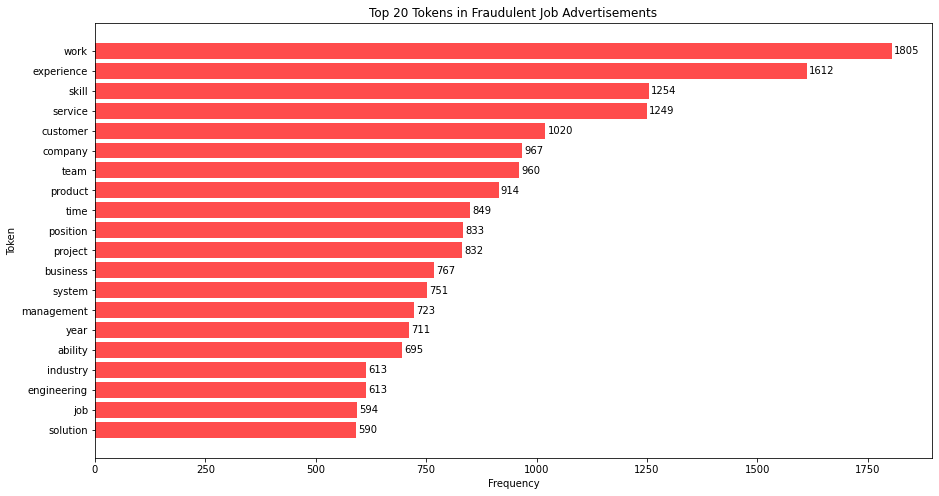

In [13]:
# Top 20 tokens in fraudulent job ads plot

#Get data
ft_dist = top_n_words(fraud_tokens, 20)
top_ft, ft_freq = list(), list()
for i in range(20):
    top_ft.append(ft_dist[-(i+1)][0])
    ft_freq.append(ft_dist[-(i+1)][1])
    
#Make plot
plt.figure(figsize=(15,8))
plt.barh(top_ft, ft_freq, color='red', alpha=.7)
plt.title('Top 20 Tokens in Fraudulent Job Advertisements')
plt.ylabel('Token')
plt.xlabel('Frequency')
for i in range(20):
    plt.text(ft_freq[i] + 5, i, ft_freq[i], color='black',
             ha='left', va='center')
plt.show()

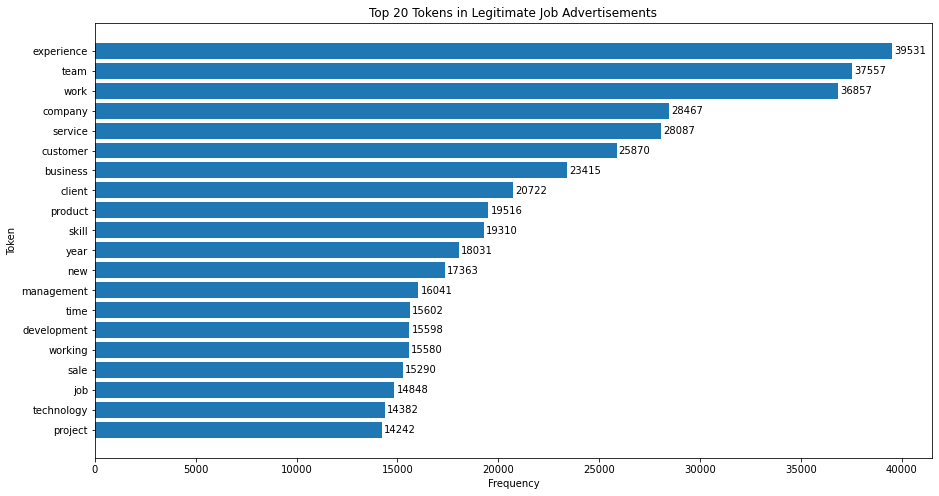

In [14]:
# Top 20 tokens in legitimate job ads plot

#Get data
lt_dist = top_n_words(legit_tokens, 20)
top_lt, lt_freq = list(), list()
for i in range(20):
    top_lt.append(lt_dist[-(i+1)][0])
    lt_freq.append(lt_dist[-(i+1)][1])

#Make plot
plt.figure(figsize=(15,8))
plt.barh(top_lt, lt_freq)
plt.title('Top 20 Tokens in Legitimate Job Advertisements')
plt.ylabel('Token')
plt.xlabel('Frequency')
for i in range(20):
    plt.text(lt_freq[i] + 100, i, lt_freq[i], color='black',
             ha='left', va='center')
plt.show()

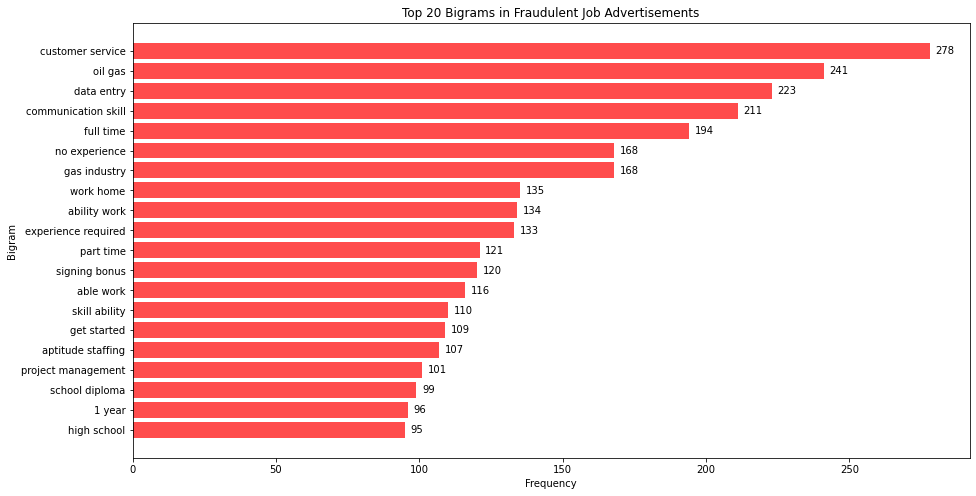

In [15]:
# Top 20 bigrams in fraudulent job ads plot

#Get data
fb_dist = top_n_words(fraud_bigrams, 20)
top_fb, fb_freq = list(), list()
for i in range(20):
    top_fb.append(fb_dist[-(i+1)][0])
    fb_freq.append(fb_dist[-(i+1)][1])
top_fb[14] = 'no experience'

#Make plot
plt.figure(figsize=(15,8))
plt.barh(top_fb, fb_freq, color='red', alpha=0.7)
plt.title('Top 20 Bigrams in Fraudulent Job Advertisements')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
for i in range(20):
    plt.text(fb_freq[i] + 2, i, fb_freq[i], color='black',
             ha='left', va='center')
plt.show()

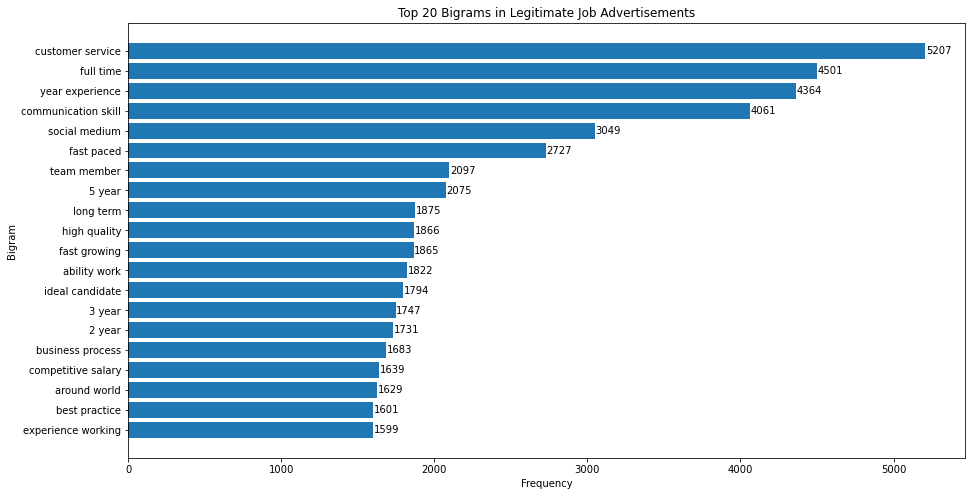

In [16]:
# Top 20 bigrams in legitimate job ads plot

#Get data
lb_dist = top_n_words(legit_bigrams, 20)
top_lb, lb_freq = list(), list()
for i in range(20):
    top_lb.append(lb_dist[-(i+1)][0])
    lb_freq.append(lb_dist[-(i+1)][1])

#Make plot
plt.figure(figsize=(15,8))
plt.barh(top_lb, lb_freq)
plt.title('Top 20 Bigrams in Legitimate Job Advertisements')
plt.ylabel('Bigram')
plt.xlabel('Frequency')
for i in range(20):
    plt.text(lb_freq[i] + 5, i, lb_freq[i], color='black',
             ha='left', va='center')
plt.show()

The fraudulent job ads in the EMSCAD do not appear to be significantly different from the legitimate job ads in terms of tokens. We can see that words such as “work”, “experience”, “skill”, “customer”, and “company” are frequently found in both types of ads.

However, the fraudulent job ads are noticeably different from the legitimate job ads when it comes to bigrams. Fraudulent job ads often contain bigrams such as “data entry”, “no experience”, “work home”, “part time”, “signing bonus”, “get started”, and “high school” which do not appear in the top 20 bigrams for legitimate job ads. Conversely, the bigrams “fast paced”, “team member”, “5 year”, “long term”, “high quality”, “fast growing”, and “competitive salary” are unique to legitimate job ads.

In [17]:
# Word cloud texts
fraud_text, legit_text = '', ''
for i in range(len(df)):
    if df.fraudulent[i] == 1:
        fraud_text += ' '.join(df.tokens[i])
    else:
        legit_text += ' '.join(df.tokens[i])

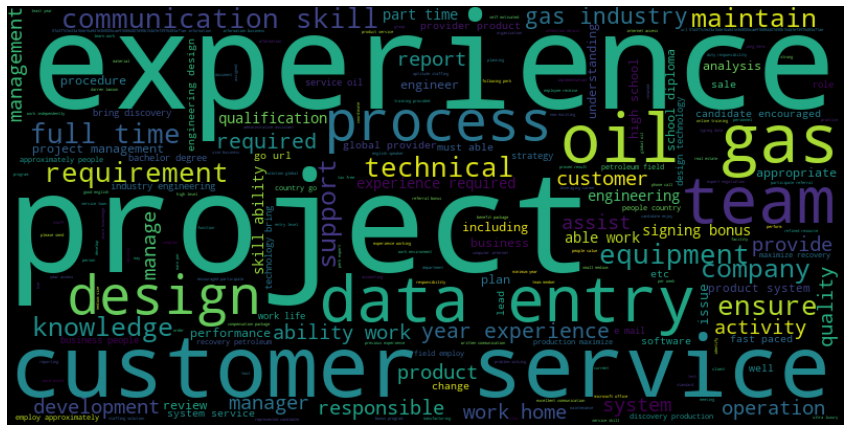

In [18]:
#Fraudulent job ads word cloud
fraud_wc = WordCloud(width=800, height=400).generate(fraud_text)
plt.figure(figsize=(15,8))
plt.imshow(fraud_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

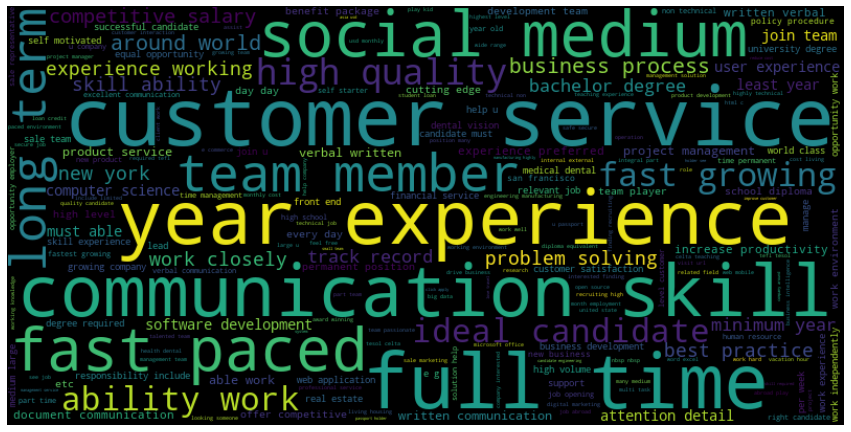

In [19]:
#Legitimate job ads word cloud
legit_wc = WordCloud(width=800, height=400).generate(legit_text)
plt.figure(figsize=(15,8))
plt.imshow(legit_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Part 4: Variable Extraction

In this section, we create a set of binary / numeric variables from the EMSCAD text features which can be used in a logistic regression model to predict job advertisement scams.

In [20]:
#Common bigrams unique to fraudulent job ads
common_fb = ['data entry', 'oil gas', 'gas industry', 'no experience',
             'experience required', 'work home', 'part time', 'signing bonus',
             'get started', 'high school', 'school diploma']

# Fraudulent bigram indicator
def has_fb(bigram_list):
    if any([bigram in common_fb for bigram in bigram_list]):
        return 1
    else:
        return 0

df['has_fraud_bigram'] = df.apply(lambda x: [has_fb(x.bigrams)], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0


In [21]:
#Common bigrams unique to legitimate job ads
common_lb = ['full time', '5 year', '3 year', '2 year', 'long term',
                'team member', 'high quality', 'fast growing',
                'fast paced', 'ideal candidate', 'competitive salary']

# Legitimate bigram indicator
def has_lb(bigram_list):
    if any([bigram in common_lb for bigram in bigram_list]):
        return 1
    else:
        return 0
    
df['has_legit_bigram'] = df.apply(lambda x: [has_lb(x.bigrams)], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram,has_legit_bigram
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1,1
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0,1
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1,1
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0,1
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0,1


In [22]:
# Merge text features function
def merge_text(x):
    cp = x.company_profile
    d = x.description
    r = x.requirements
    b = x.benefits
    return cp + d + r + b

In [23]:
# Email indicator
def email(text):
    if '#EMAIL' in text:
        return 1
    else:
        return 0
    
df['has_email'] = df.apply(lambda x: [email(merge_text(x))], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram,has_legit_bigram,has_email
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1,1,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0,1,0
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1,1,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0,1,0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0,1,0


In [24]:
# Phone number indicator
def phone(text):
    if '#PHONE' in text:
        return 1
    else:
        return 0
    
df['has_phone'] = df.apply(lambda x: [phone(merge_text(x))], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram,has_legit_bigram,has_email,has_phone
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1,1,0,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0,1,0,0
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1,1,0,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0,1,0,0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0,1,0,1


In [25]:
# External URL address indicator
def url(text):
    if '#URL' in text:
        return 1
    else:
        return 0
    
df['has_url'] = df.apply(lambda x: [url(merge_text(x))], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram,has_legit_bigram,has_email,has_phone,has_url
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1,1,0,0,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0,1,0,0,1
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1,1,0,0,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0,1,0,0,0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0,1,0,1,0


In [26]:
# Money in title indicator
def money_in_title(text):
    if '$' in text:
        return 1
    else:
        return 0
    
df['money_in_title'] = df.apply(lambda x: [money_in_title(x.title)], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram,has_legit_bigram,has_email,has_phone,has_url,money_in_title
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1,1,0,0,0,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0,1,0,0,1,0
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1,1,0,0,0,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0,1,0,0,0,0
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0,1,0,1,0,0


In [27]:
# Text feature lengths
def word_count(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return len(text.split())

df['company_profile_length'] = df.apply(lambda x: [word_count(x.company_profile)], axis=1, result_type='expand')
df['description_length'] = df.apply(lambda x: [word_count(x.description)], axis=1, result_type='expand')
df['requirements_length'] = df.apply(lambda x: [word_count(x.requirements)], axis=1, result_type='expand')
df['benefits_length'] = df.apply(lambda x: [word_count(x.benefits)], axis=1, result_type='expand')
df.head()

,job_id,title,company_profile,description,requirements,benefits,fraudulent,tokens,bigrams,has_fraud_bigram,has_legit_bigram,has_email,has_phone,has_url,money_in_title,company_profile_length,description_length,requirements_length,benefits_length
0,1,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"[food52, created, groundbreaking, award, winni...","[food52 created, created groundbreaking, groun...",1,1,0,0,0,0,150,132,119,0
1,2,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,"[90, second, world, cloud, video, production, ...","[90 second, second world, world cloud, cloud v...",0,1,0,0,1,0,170,324,198,235
2,3,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,"[valor, service, provides, workforce, solution...","[valor service, service provides, provides wor...",1,1,0,0,0,0,143,50,187,0
3,4,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"[passion, improving, quality, life, geography,...","[passion improving, improving quality, quality...",0,1,0,0,0,0,90,355,181,107
4,5,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"[spotsource, solution, llc, global, human, cap...","[spotsource solution, solution llc, llc global...",0,1,0,1,0,0,214,179,93,3


In [28]:
# Drop columns that are no longer needed
df.drop(['title', 'company_profile', 'description', 'requirements',
         'benefits', 'tokens', 'bigrams', 'fraudulent'], inplace=True, axis=1)
df.head()

,job_id,has_fraud_bigram,has_legit_bigram,has_email,has_phone,has_url,money_in_title,company_profile_length,description_length,requirements_length,benefits_length
0,1,1,1,0,0,0,0,150,132,119,0
1,2,0,1,0,0,1,0,170,324,198,235
2,3,1,1,0,0,0,0,143,50,187,0
3,4,0,1,0,0,0,0,90,355,181,107
4,5,0,1,0,1,0,0,214,179,93,3


In [29]:
# Export text mining results as CSV file
df.to_csv('text_mining_results.csv', index=False)